In [2]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv

In [9]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

# SCP (Perlmutter Group) Dataset Phase Space

In [36]:
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
#nothing

In [37]:
redshift = data_scp.T[1]
dist_mod = data_scp.T[2] #pc
dist_mod_err = data_scp.T[3] #pc

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.  
indx = redshift<0.03
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
print(H0)
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


68.38635488860305


In [38]:
def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms

Matter Density is: 0.15254237288135594
Dark Energy Density is: 0.4044943820224719


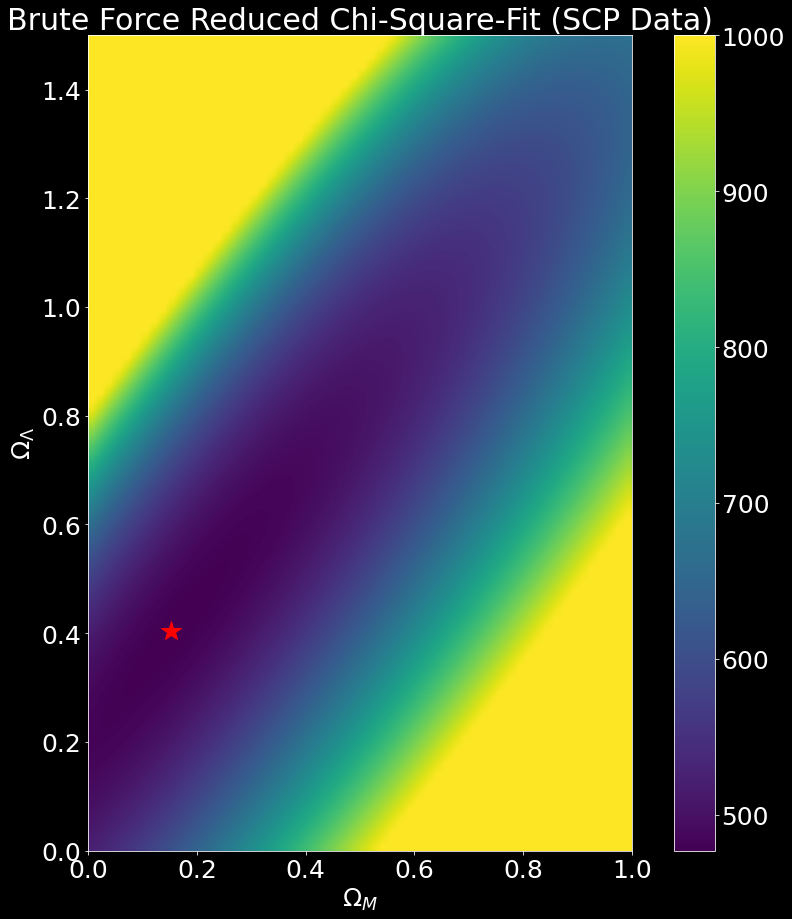

In [39]:

Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SCP Data)')
plt.show()

# SNLS Data

Matter Density is: 0.13559322033898305
Dark Energy Density is: 0.5561797752808989


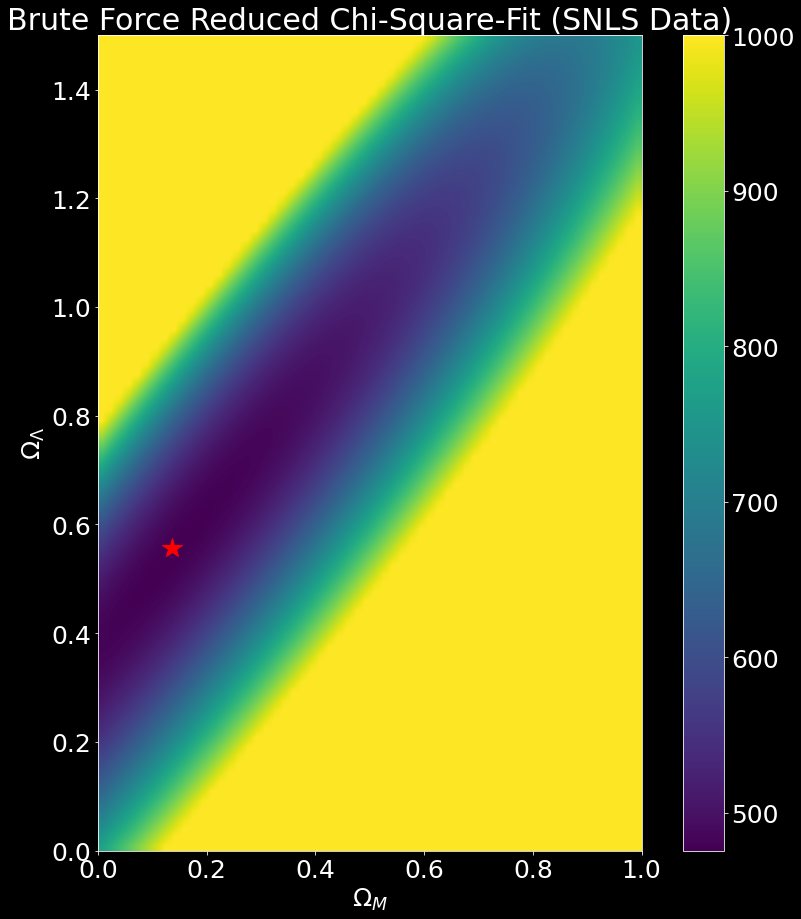

In [70]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
redshift = data_snls.T[1]
color_error = data_snls.T[9]
dist_mod = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)


redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms


Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SNLS Data)')

plt.show()

# HyperLeda Phase Space

In [72]:
import pandas as pd

In [73]:
df = pd.read_csv('HyperLeda_Updated.csv').dropna()
df = df.where(df.where(df['mod_mpc']<100).dropna()['v_gsr']<15000).dropna()
df = df.where(df['v_gsr']/3e5>0.01).dropna()
df = df.where(df['v_gsr']/3e5>0).dropna()
df

,objname,e_mod0,mod0,v_gsr,mod_mpc
14,PGC2793293,0.200,34.348,4478.2,74.062778
52,2MASXJ09591870-1928233,0.098,34.180,3438.9,68.548823
335,UGC00272,0.176,33.723,3988.3,55.539249
385,IC4595,0.365,32.872,3274.7,37.531852
389,ESO107-015,0.400,32.810,3267.9,36.475395
...,...,...,...,...,...
4200,NGC5698,0.049,34.019,3734.2,63.650233
4205,PGC053805,0.370,34.720,14906.5,87.902252
4213,NGC7112,0.346,34.264,6035.7,71.252482
4226,IC4567,0.350,34.005,5866.5,63.241185


In [74]:
redshift = np.array(df['v_gsr']/3e5)
dist_mod = np.array(df['mod0'])
dist_mod_err = np.array(df['e_mod0'])

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


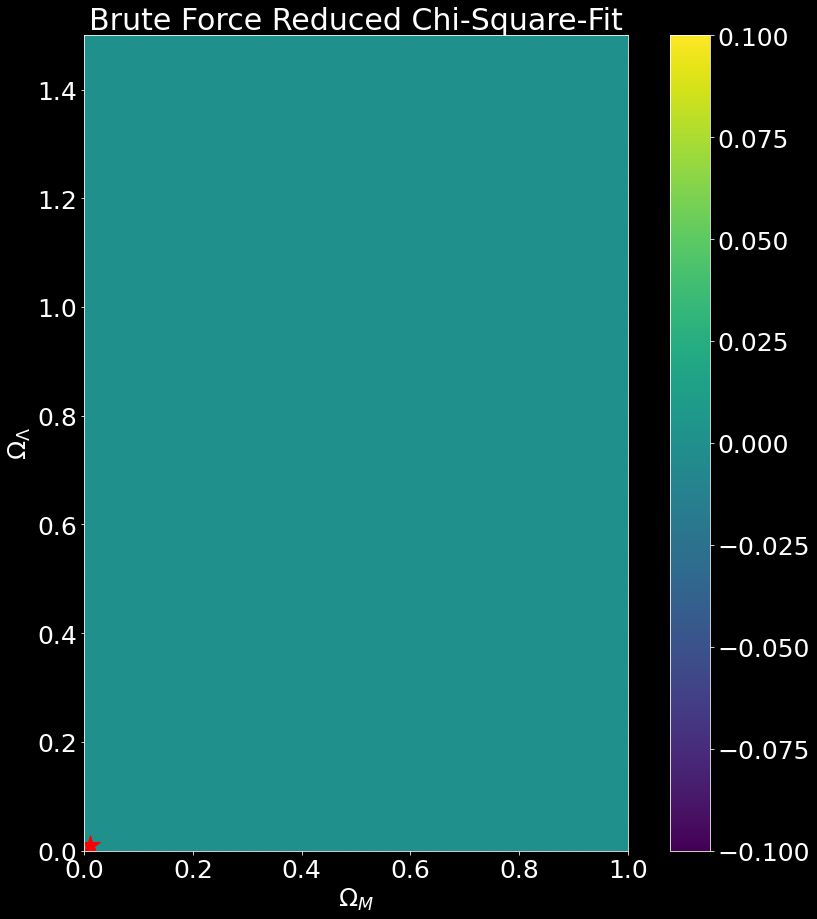

In [77]:

Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.01,1,Nomega_m)
omega_Ls = np.linspace(0.01,1,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

# plot the chisq and contours
plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit')
plt.show()